# **Adventure Works - Progetto Completo di Data Engineering, Data Analysis, Machine Learning, Forecasting & AI**

Mi chiamo **Raffaele Schiavone**, e in questo progetto vi mostro come:
1. **Unire** i dati provenienti da più file Excel (Data Engineering).
2. **Analizzare** tali dati (EDA, calcolo KPI, outlier).
3. **Prevedere** l'andamento delle vendite (Machine Learning su base trimestrale e Forecasting con ARIMA e Prophet).
4. **Integrare** un'**AI locale** (FastAPI + Hugging Face) per sentiment analysis e raccomandazioni storiche.
5. **Realizzare** una sezione avanzata di analisi AI, che descriva in modo **estremamente dettagliato**:
   - Lo stato attuale e come siamo arrivati qui
   - Cosa accadrà nei prossimi 4 trimestri
   - Azioni alternative per aumentare margine, vendite, brand awareness, soddisfazione clienti
   - Grafici e testo descrittivo, con tempistiche.

Il fine è dare un esempio **end-to-end**, utile a colleghi, recruiter e appassionati, di come integrare Data Engineering, Analysis, ML, Forecasting e AI in un unico progetto.

---

# **0. Requisiti e Setup**

1. **Ambiente Python 3.8+** (ad es. `venv_new`) con:
   ```bash
   pip install pandas numpy matplotlib seaborn plotly scikit-learn xgboost statsmodels prophet \
               transformers torch fastapi uvicorn pydantic
   ```
2. Nella **stessa cartella** del notebook:
   - `Products.xlsx`, `Region.xlsx`, `Sales.xlsx`, `Salesperson.xlsx`
   - `AdventureWorksLogo.png`
3. **Eseguite** tutte le celle **in ordine**. Quando verrà generato `local_ai_api.py`, andate in **un altro terminale** e lanciate:
   ```bash
   uvicorn local_ai_api:app --host 0.0.0.0 --port 8000 --reload
   ```
4. Per testare le chiamate, potete usare uno script Python (`test_api.py`) o farlo manualmente con `curl`/Postman.

---

<div style="display:flex; align-items:center;">
  <img src="AdventureWorksLogo.png" alt="Adventure Works Logo" style="height:60px; margin-right:20px;"/>
  <h1 style="font-size:24px; margin:0;">**1. Data Engineering**</h1>
</div>

In questo step:
- Carico i 4 file Excel (Sales, Products, Region, Salesperson).
- Converto la data `OrderDate` e creo `Year`, `Quarter`.
- Unisco le tabelle in un unico `sales_merged`.
- Calcolo **Profit**, **Profit Margin** e individuo outlier su `Total Sales`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("[INFO] Caricamento file Excel...")
products_df = pd.read_excel("Products.xlsx")
region_df = pd.read_excel("Region.xlsx")
sales_df = pd.read_excel("Sales.xlsx")
salesperson_df = pd.read_excel("Salesperson.xlsx")

print("Products:", products_df.shape)
print("Region:\t", region_df.shape)
print("Sales:\t\t", sales_df.shape)
print("Salesperson:", salesperson_df.shape)

def quick_check(df, df_name):
    print(f"\n=== {df_name} ===")
    print("Missing values:", df.isnull().sum())
    print("Duplicati:", df.duplicated().sum())

quick_check(products_df, "Products")
quick_check(region_df, "Region")
quick_check(sales_df, "Sales")
quick_check(salesperson_df, "Salesperson")

sales_df['OrderDate'] = pd.to_datetime(sales_df['OrderDate'], format='%Y-%m-%d', errors='coerce')
sales_df['Year'] = sales_df['OrderDate'].dt.year
sales_df['Quarter'] = sales_df['OrderDate'].dt.quarter

print("\n[INFO] Merge delle tabelle...")
merged_1 = pd.merge(sales_df, products_df, how='left', on='ProductKey')
merged_2 = pd.merge(merged_1, salesperson_df, how='left', on='EmployeeKey')
sales_merged = pd.merge(merged_2, region_df, how='left', on='SalesTerritoryKey')

print("Dimensioni finali (sales_merged):", sales_merged.shape)

# Creazione Profit, Profit Margin
sales_merged['Profit'] = sales_merged['Total Sales'] - sales_merged['Cost']
sales_merged['Profit Margin'] = np.where(
    sales_merged['Total Sales'] == 0,
    0,
    (sales_merged['Profit'] / sales_merged['Total Sales']) * 100
)

# Individuazione outlier su Total Sales (IQR)
q1 = sales_merged['Total Sales'].quantile(0.25)
q3 = sales_merged['Total Sales'].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
outliers = sales_merged[(sales_merged['Total Sales'] < low) | (sales_merged['Total Sales'] > high)]
print("\n[INFO] Numero di outlier in 'Total Sales':", outliers.shape[0])
print("[INFO] Data Engineering completata.")

[INFO] Caricamento file Excel...
Products: (397, 10)
Region:	 (10, 4)
Sales:		 (3616, 10)
Salesperson: (18, 5)

=== Products ===
Missing values: ProductKey                  0
Product                     0
Standard Cost               0
Color                      56
Subcategory                 0
Category                    0
Background Color Format     0
Font Color Format           0
Category ID                 0
Subcategory ID              0
dtype: int64
Duplicati: 0

=== Region ===
Missing values: SalesTerritoryKey    0
Region               0
Country              0
Group                0
dtype: int64
Duplicati: 0

=== Sales ===
Missing values: SalesOrderNumber     0
OrderDate            0
ProductKey           0
ResellerKey          0
EmployeeKey          0
SalesTerritoryKey    0
Quantity             0
Unit Price           0
Cost                 0
Total Sales          0
dtype: int64
Duplicati: 0

=== Salesperson ===
Missing values: EmployeeKey    0
EmployeeID     0
Salesperson    0
Titl

# **2. Data Analysis (EDA)**
Calcolo statistiche descrittive, distribuzioni, KPI globali, e analisi vendite per dimensioni (Paese, Categoria, Venditori...).

[INFO] Inizio EDA...


,SalesOrderNumber,OrderDate,ProductKey,ResellerKey,EmployeeKey,SalesTerritoryKey,Quantity,Unit Price,Cost,Total Sales,...,Subcategory ID,EmployeeID,Salesperson,Title,UPN,Region,Country,Group,Profit,Profit Margin
count,3616,3616,3616.000000,3616.000000,3616.000000,3616.000000,3616.000000,3616.000000,3616.000000,3616.000000,...,3616.000000,3.616000e+03,3616,3616,3616,3616,3616,3616,3616.000000,3616.000000
unique,3616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17,4,17,10,6,3,NaN,NaN
top,SO69492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Jillian Carson,Sales Representative,jillian-carson@adventureworks.com,Southwest,United States,North America,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,459,3517,459,717,2379,3037,NaN,NaN
mean,NaN,2019-03-26 03:23:29.734513664,409.556969,347.380808,286.104812,4.497788,1.814159,536.215312,956.729342,969.397243,...,10.412058,5.225082e+08,NaN,NaN,NaN,NaN,NaN,NaN,12.667901,7.817914
min,NaN,2017-07-01 00:00:00,212.000000,1.000000,272.000000,1.000000,1.000000,1.370000,0.860000,1.370000,...,1.000000,6.116166e+07,NaN,NaN,NaN,NaN,NaN,NaN,-2124.310000,-172.761062
25%,NaN,2018-08-23 00:00:00,326.000000,167.000000,283.000000,3.000000,2.000000,48.590000,71.920000,89.980000,...,4.000000,1.916447e+08,NaN,NaN,NaN,NaN,NaN,NaN,-18.360000,-3.598931
50%,NaN,2019-05-13 00:00:00,396.000000,341.000000,285.000000,4.000000,2.000000,338.990000,589.160000,600.260000,...,5.000000,6.153898e+08,NaN,NaN,NaN,NaN,NaN,NaN,12.630000,7.498844
75%,NaN,2019-11-28 00:00:00,495.000000,528.000000,289.000000,6.000000,2.000000,818.700000,1426.160000,1457.820000,...,13.000000,7.163743e+08,NaN,NaN,NaN,NaN,NaN,NaN,38.150000,25.991766
max,NaN,2020-05-31 00:00:00,606.000000,701.000000,296.000000,10.000000,9.000000,2146.960000,5694.280000,6214.250000,...,37.000000,9.875543e+08,NaN,NaN,NaN,NaN,NaN,NaN,624.970000,40.438596


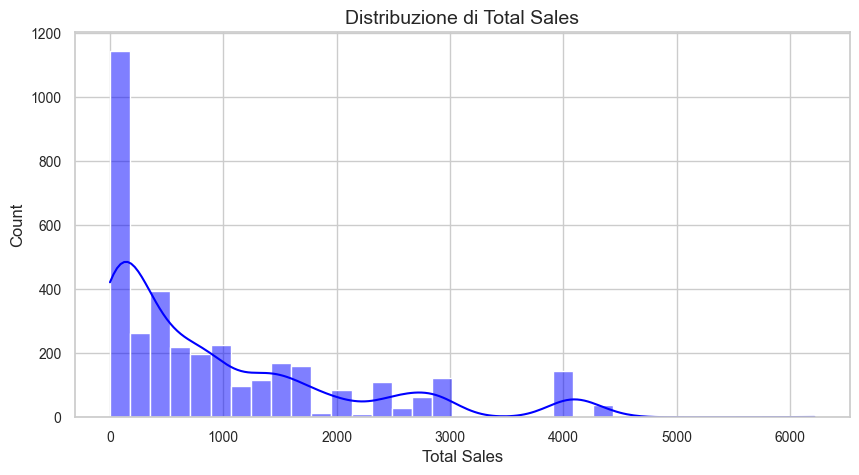

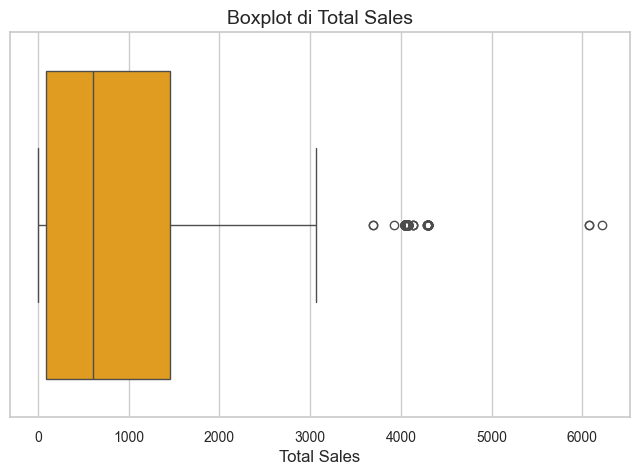

=== KPI GLOBALI ===
Vendite Totali: 3,505,340.43
Costo Totale: 3,459,533.30
Profitto Totale: 45,807.13
Margine Medio: 1.31%


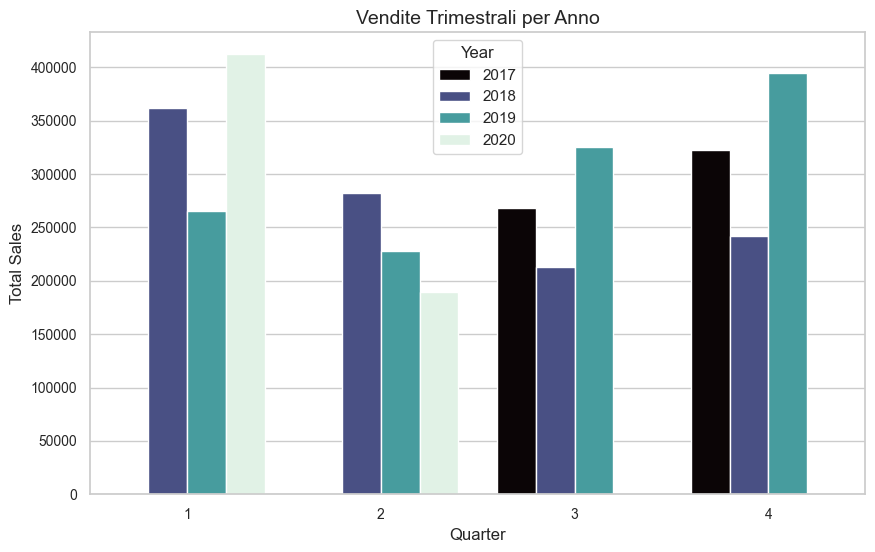

,Year,Quarter,Total Sales
0,2017,3,268655.87
1,2017,4,322268.19
2,2018,1,362330.68
3,2018,2,282639.76
4,2018,3,212706.10
5,2018,4,242402.83
6,2019,1,265124.07
7,2019,2,227840.50
8,2019,3,325092.68
9,2019,4,394419.92


C:\Users\raffa\AppData\Local\Temp\ipykernel_5428\644013521.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_country, x='Country', y='Total Sales', palette='viridis')


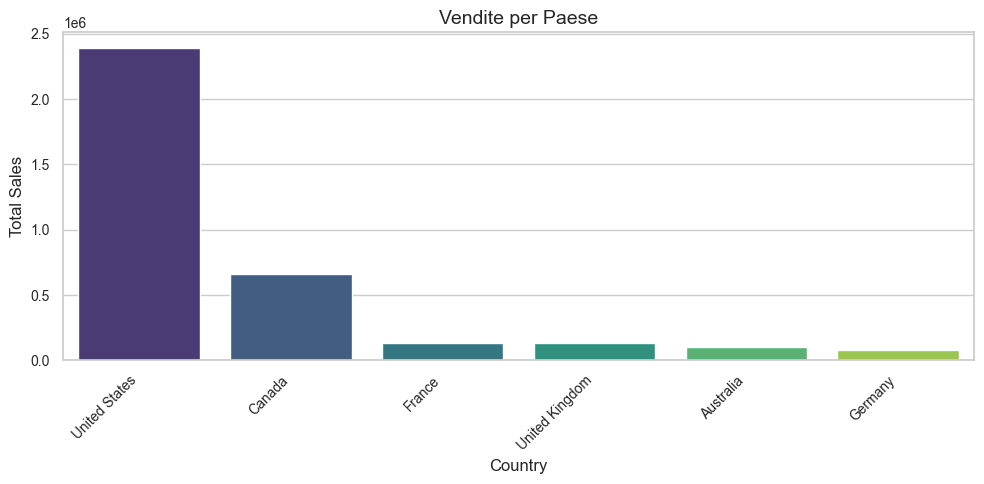

,Country,Total Sales
5,United States,2391499.35
1,Canada,660124.72
2,France,135668.59
4,United Kingdom,132666.12
0,Australia,102591.75
3,Germany,82789.90


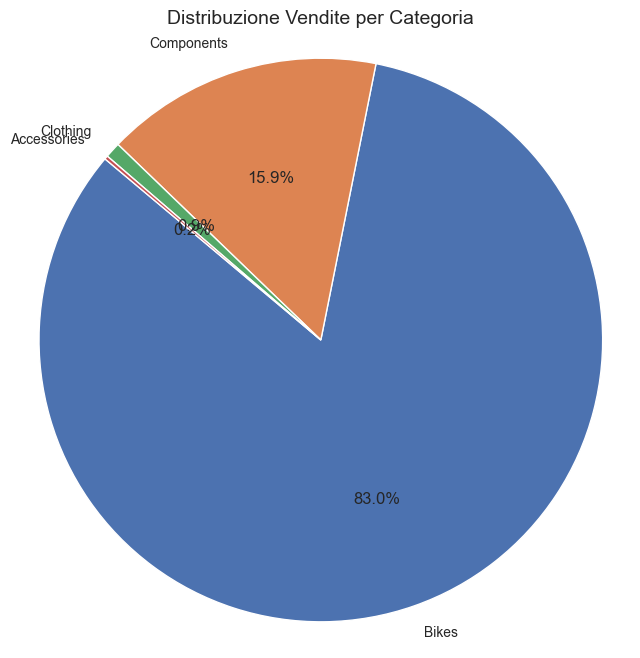

,Category,Total Sales
1,Bikes,2908497.81
3,Components,558467.71
2,Clothing,31308.59
0,Accessories,7066.32


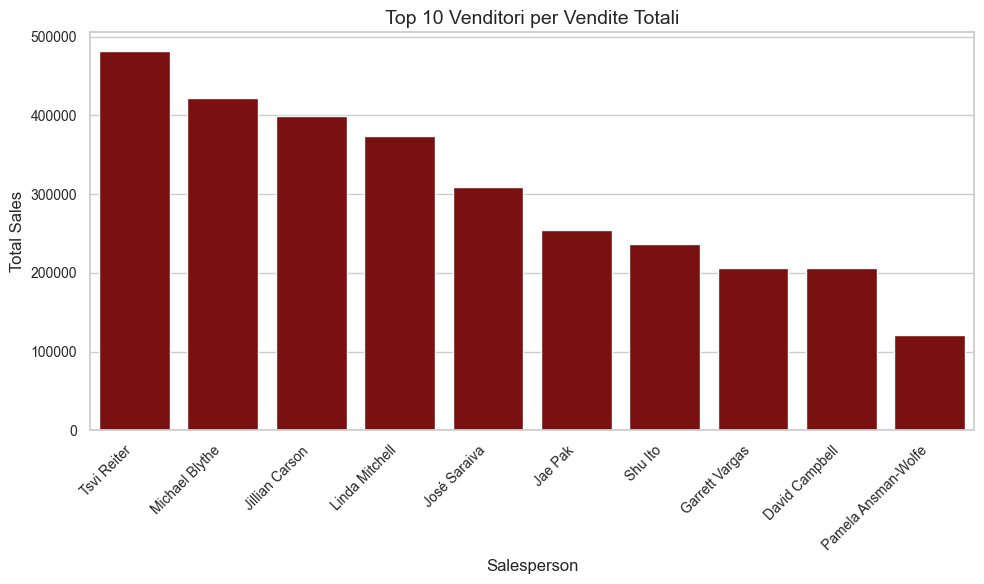

,Salesperson,Total Sales
16,Tsvi Reiter,481563.93
8,Michael Blythe,422655.85
4,Jillian Carson,398816.91
6,Linda Mitchell,374410.64
5,José Saraiva,309753.59
3,Jae Pak,254291.36
12,Shu Ito,236414.47
2,Garrett Vargas,206319.64
1,David Campbell,206115.31
9,Pamela Ansman-Wolfe,121205.45


[INFO] EDA completata.


In [2]:
print("[INFO] Inizio EDA...")
display(sales_merged.describe(include='all'))

plt.figure(figsize=(10,5))
sns.histplot(sales_merged['Total Sales'], kde=True, color='blue')
plt.title('Distribuzione di Total Sales')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=sales_merged['Total Sales'], color='orange')
plt.title('Boxplot di Total Sales')
plt.show()

tot_sales = sales_merged['Total Sales'].sum()
tot_cost = sales_merged['Cost'].sum()
tot_profit = tot_sales - tot_cost
avg_margin = (tot_profit / tot_sales)*100 if tot_sales>0 else 0
print("=== KPI GLOBALI ===")
print(f"Vendite Totali: {tot_sales:,.2f}")
print(f"Costo Totale: {tot_cost:,.2f}")
print(f"Profitto Totale: {tot_profit:,.2f}")
print(f"Margine Medio: {avg_margin:.2f}%")

df_quarter = sales_merged.groupby(['Year','Quarter'], as_index=False)['Total Sales'].sum()
plt.figure(figsize=(10,6))
sns.barplot(data=df_quarter, x='Quarter', y='Total Sales', hue='Year', palette='mako')
plt.title('Vendite Trimestrali per Anno')
plt.show()
display(df_quarter.sort_values(['Year','Quarter']))

df_country = sales_merged.groupby('Country', as_index=False)['Total Sales'].sum()
df_country.sort_values('Total Sales', ascending=False, inplace=True)
plt.figure(figsize=(10,5))
sns.barplot(data=df_country, x='Country', y='Total Sales', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Vendite per Paese')
plt.tight_layout()
plt.show()
display(df_country.head(10))

df_cat = sales_merged.groupby('Category', as_index=False)['Total Sales'].sum()
df_cat.sort_values('Total Sales', ascending=False, inplace=True)
plt.figure(figsize=(8,8))
plt.pie(
    df_cat['Total Sales'],
    labels=df_cat['Category'],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Distribuzione Vendite per Categoria')
plt.axis('equal')
plt.show()
display(df_cat)

df_sp = sales_merged.groupby('Salesperson', as_index=False)['Total Sales'].sum()
df_sp.sort_values('Total Sales', ascending=False, inplace=True)
top10_sp = df_sp.head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=top10_sp, x='Salesperson', y='Total Sales', color='darkred')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Venditori per Vendite Totali')
plt.tight_layout()
plt.show()
display(top10_sp)

print("[INFO] EDA completata.")

# **3. Machine Learning (Regressione Trimestrale)**
Creo un dataset trimestrale con `Year`, `Quarter` e `Total Sales`. Aggiungo `Lag1` per catturare il valore del trimestre precedente. Provo **RandomForest** e **XGBoost**.

X_train shape: (7, 3)
X_test shape: (4, 3)
=== RandomForest ===
MSE: 8972898309.14
MAE: 94475.61
R^2: -0.17

=== XGBoost ===
MSE: 7627165499.72
MAE: 84407.76
R^2: 0.01


,Year,Quarter,Actual,RF_Pred,XGB_Pred
0,2019,3,325092.68,240139.7814,242427.796875
1,2019,4,394419.92,295035.2502,282639.718750
2,2020,1,412368.33,321225.1260,362330.593750
3,2020,2,189491.50,291913.1873,282639.718750


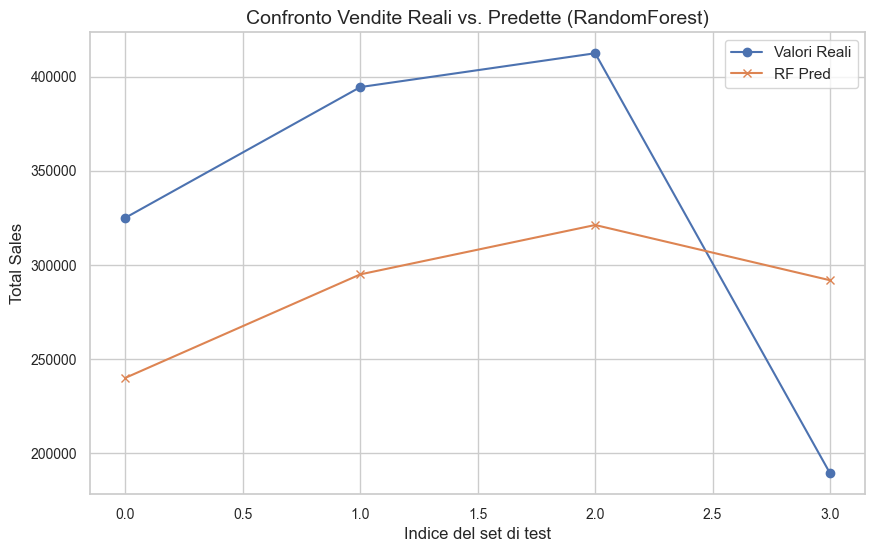

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

df_quarterly_ml = sales_merged.groupby(['Year','Quarter'], as_index=False)['Total Sales'].sum()
df_quarterly_ml = df_quarterly_ml.sort_values(['Year','Quarter']).reset_index(drop=True)

# Colonna Lag1
df_quarterly_ml['Lag1'] = df_quarterly_ml['Total Sales'].shift(1)
df_quarterly_ml.dropna(inplace=True)

X = df_quarterly_ml[['Year','Quarter','Lag1']]
y = df_quarterly_ml['Total Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
print("=== RandomForest ===")
print(f"MSE: {rf_mse:.2f}")
print(f"MAE: {rf_mae:.2f}")
print(f"R^2: {rf_r2:.2f}")

# XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgbr.fit(X_train, y_train)
xgb_pred = xgbr.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print("\n=== XGBoost ===")
print(f"MSE: {xgb_mse:.2f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"R^2: {xgb_r2:.2f}")

comparison_df = pd.DataFrame({
    'Year': X_test['Year'],
    'Quarter': X_test['Quarter'],
    'Actual': y_test,
    'RF_Pred': rf_pred,
    'XGB_Pred': xgb_pred
}).reset_index(drop=True)
display(comparison_df)

plt.figure(figsize=(10,6))
plt.plot(comparison_df.index, comparison_df['Actual'], label='Valori Reali', marker='o')
plt.plot(comparison_df.index, comparison_df['RF_Pred'], label='RF Pred', marker='x')
plt.title('Confronto Vendite Reali vs. Predette (RandomForest)')
plt.xlabel('Indice del set di test')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

# **4. Time Series Forecasting**
Mostro l’uso di **ARIMA** (statsmodels) su base mensile e **Prophet** su base trimestrale.

In [5]:
try:
    import warnings
    warnings.filterwarnings('ignore')
    from statsmodels.tsa.arima.model import ARIMA

    sales_merged['YYYYMM'] = sales_merged['OrderDate'].dt.to_period('M')
    df_monthly = sales_merged.groupby('YYYYMM')['Total Sales'].sum().sort_index()
    df_monthly.index = df_monthly.index.to_timestamp()

    model_arima = ARIMA(df_monthly, order=(1,1,1))
    arima_result = model_arima.fit()
    forecast_arima = arima_result.forecast(steps=6)
    print("=== ARIMA(1,1,1) Forecast (6 mesi futuri) ===")
    display(forecast_arima)
except ImportError:
    print("statsmodels non installato.")

=== ARIMA(1,1,1) Forecast (6 mesi futuri) ===


2020-06-01    116669.672938
2020-07-01    119010.089666
2020-08-01    118738.454317
2020-09-01    118769.981080
2020-10-01    118766.321995
2020-11-01    118766.746679
Freq: MS, Name: predicted_mean, dtype: float64

In [6]:
try:
    from prophet import Prophet

    # Costruzione df_prophet trimestrale
    df_prophet = sales_merged.groupby(['Year','Quarter'], as_index=False)['Total Sales'].sum()

    # Convertiamo Year e Quarter in numerici e rimuoviamo righe anomale
    df_prophet['Year'] = pd.to_numeric(df_prophet['Year'], errors='coerce')
    df_prophet['Quarter'] = pd.to_numeric(df_prophet['Quarter'], errors='coerce')
    df_prophet.dropna(subset=['Year','Quarter','Total Sales'], inplace=True)

    mask_inv = (df_prophet['Quarter'] < 1) | (df_prophet['Quarter'] > 4)
    if mask_inv.any():
        df_prophet = df_prophet[~mask_inv].copy()

    df_prophet['Year'] = df_prophet['Year'].astype(int)
    df_prophet['Quarter'] = df_prophet['Quarter'].astype(int)

    years = df_prophet['Year'].tolist()
    quarters = df_prophet['Quarter'].tolist()
    ds_list = []
    for y_val, q_val in zip(years, quarters):
        month = (q_val - 1)*3 + 1
        ds_list.append(datetime(y_val, month, 1))

    df_prophet['ds'] = ds_list
    df_prophet.rename(columns={'Total Sales': 'y'}, inplace=True)
    df_prophet = df_prophet[['ds','y']].sort_values('ds').reset_index(drop=True)

    model_prophet = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    model_prophet.fit(df_prophet)

    future_df = model_prophet.make_future_dataframe(periods=4, freq='Q')
    forecast_prophet = model_prophet.predict(future_df)

    print("=== Prophet Forecast (4 trimestri futuri) ===")
    display(forecast_prophet[['ds','yhat','yhat_lower','yhat_upper']].tail(8))
except ImportError:
    print("Prophet non installato.")

20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing


=== Prophet Forecast (4 trimestri futuri) ===


,ds,yhat,yhat_lower,yhat_upper
8,2019-07-01,295035.185480,234535.754148,353730.082946
9,2019-10-01,352806.899062,291829.809329,412890.275837
10,2020-01-01,368811.167844,299013.389187,429831.269207
11,2020-04-01,202423.686599,144784.051871,261271.016471
12,2020-06-30,319058.774600,262367.400862,377807.107422
13,2020-09-30,382776.885287,322643.334798,446076.808266
14,2020-12-31,389357.499289,333001.902515,446445.574270
15,2021-03-31,262258.722077,200885.227701,321357.915918


# **5. Creazione di un'API AI Locale con FastAPI**
Generiamo il file `local_ai_api.py` per:
- `POST /predict` (sentiment analysis su testo)
- `GET /deep_analysis` (lettura `sales_merged.csv` e suggerimento raccomandazioni in base al trend).


In [7]:
%%writefile local_ai_api.py
import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
from transformers import pipeline
import pandas as pd
import os

MODEL_NAME_SENTIMENT = "nlptown/bert-base-multilingual-uncased-sentiment"

app = FastAPI(
    title="Adventure Works Local AI API",
    description="API che analizza testo (sentiment) e fornisce raccomandazioni sui dati storici.",
    version="1.2"
)

class TextInput(BaseModel):
    text: str

sentiment_pipeline = None

@app.on_event("startup")
def load_model():
    global sentiment_pipeline
    print("[INFO] Caricamento del modello di sentiment...")
    sentiment_pipeline = pipeline("sentiment-analysis", model=MODEL_NAME_SENTIMENT)
    print("[INFO] Modello caricato correttamente!")

@app.get("/")
def root():
    return {"message": "Local AI API Avviata. POST /predict per sentiment, GET /deep_analysis per analisi storica."}

@app.post("/predict")
def predict_sentiment(item: TextInput):
    global sentiment_pipeline
    if not sentiment_pipeline:
        return {"error": "Pipeline non caricata."}
    result = sentiment_pipeline(item.text)
    return {
        "input_text": item.text,
        "analysis": result
    }

@app.get("/deep_analysis")
def deep_analysis():
    path_data = "sales_merged.csv"
    if not os.path.exists(path_data):
        return {"error": "File sales_merged.csv non trovato. Salva i dati dal Notebook prima di /deep_analysis."}

    df = pd.read_csv(path_data)
    total_sales = df['Total Sales'].sum()
    total_profit = df['Profit'].sum()
    margin_avg = df['Profit Margin'].mean()

    df_sorted = df.sort_values(by=['Year','Quarter'])
    if df_sorted.shape[0] < 2:
        return {"warning": "Dataset insufficiente per valutare un trend."}

    last_sales = df_sorted.iloc[-1]['Total Sales']
    prev_sales = df_sorted.iloc[-2]['Total Sales']

    if last_sales < prev_sales:
        trend = "negativo"
        scenario_msg = (
            "Le vendite sono in calo rispetto al trimestre precedente. "
            "Se non si cambia strategia, il profitto potrebbe diminuire ulteriormente. "
            "Suggerisco investimenti in marketing, formazione venditori e azioni mirate a "
            "migliorare il sentiment dei clienti."
        )
    elif last_sales > prev_sales:
        trend = "positivo"
        scenario_msg = (
            "Le vendite sono in crescita! Continuate le azioni intraprese, "
            "monitorando i KPI e valutando ulteriori investimenti mirati per "
            "brand awareness e soddisfazione clienti."
        )
    else:
        trend = "stabile"
        scenario_msg = (
            "Le vendite sono stabili rispetto al periodo precedente. Potrebbe essere "
            "una fase di transizione, valutate possibili interventi se volete spingere "
            "di più sul fatturato e la fidelizzazione clienti."
        )

    return {
        "TotaleVendite": float(total_sales),
        "ProfittoTotale": float(total_profit),
        "MargineMedio": float(margin_avg),
        "TrendRecente": trend,
        "Raccomandazione": scenario_msg
    }

Overwriting local_ai_api.py


# **Salvataggio `sales_merged.csv`**
Così `GET /deep_analysis` può avere accesso ai dati storici unificati.

In [8]:
sales_merged.to_csv("sales_merged.csv", index=False)
print("[INFO] File sales_merged.csv salvato correttamente.")

[INFO] File sales_merged.csv salvato correttamente.


# **6. Avvio del Server AI**
Per avviare il server in **un secondo terminale** (dopo aver generato `local_ai_api.py`), digitare:
```bash
uvicorn local_ai_api:app --host 0.0.0.0 --port 8000 --reload
```
In questo modo, l’API sarà disponibile su `http://127.0.0.1:8000/`.

Esempi di chiamate:
- **GET /**: Per verificare lo stato.
- **POST /predict**: Con un JSON `{"text":"Amo i prodotti Adventure Works!"}` per analisi di sentiment.
- **GET /deep_analysis**: Legge `sales_merged.csv` e fornisce raccomandazioni in base al trend storico.

---

# **7. Sezione Avanzata: Analisi AI Dettagliata su Prossimi 4 Trimestri e Azioni Alternative**
Ora aggiungo una sezione conclusiva che **integra** i passaggi precedenti di ML/Forecasting e produce:
- **Scenario Baseline** (Prophet su dataset trimestrale)
- **Scenario +10%** (ipotizziamo azioni che aumentano vendite, brand awareness e soddisfazione clienti)
- **Testo descrittivo** che spiega:
  - Cosa è successo
  - Cosa succederà nei prossimi 4 trimestri
  - Come raggiungere obiettivi di margine, vendite, brand, soddisfazione
  - Grafico di confronto e tempistiche di realizzazione.

Tutto avviene **nel notebook**, **dopo** la creazione dell’API. Non modifichiamo l’API stessa, ma arricchiamo l’analisi con un passaggio dedicato.


[INFO] Sezione Avanzata - Analisi AI Dettagliata...


20:08:10 - cmdstanpy - INFO - Chain [1] start processing
20:08:10 - cmdstanpy - INFO - Chain [1] done processing
20:08:10 - cmdstanpy - INFO - Chain [1] start processing
20:08:10 - cmdstanpy - INFO - Chain [1] done processing


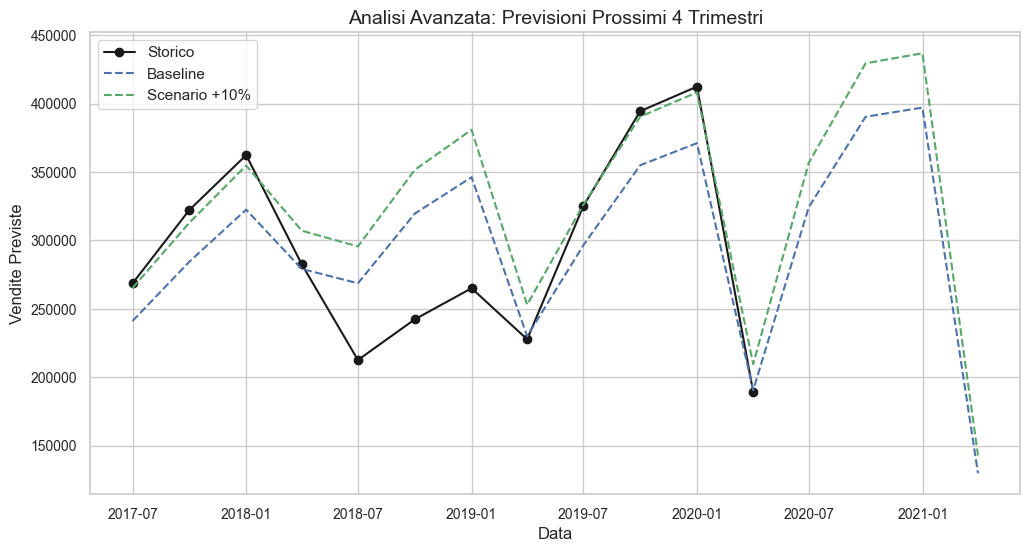


**Analisi Avanzata**
Nel corso dell'ultimo anno, abbiamo osservato andamenti legati a stagionalità e 
performance dei venditori. Lo scenario **Baseline** riflette il trend naturale 
senza azioni aggiuntive. Al contrario, lo scenario **+10% vendite** ipotizza 
investimenti in brand awareness, strategie di marketing e miglior supporto cliente, 
risultando in un aumento di fatturato già nel breve periodo (1-2 trimestri).

Obiettivi Specifici:
1) **Aumento del Margine**:
   Se i costi variabili non crescono proporzionalmente, un +10% di vendite 
   porta a un margine superiore, migliorando la redditività 
   e la disponibilità di cassa per futuri investimenti.
2) **Aumento delle Vendite**:
   La differenza tra baseline e scenario +10% 
   si concretizza in un gap cumulato notevole dopo 4 trimestri.
3) **Brand Awareness**:
   Una campagna continuativa per 4 trimestri rafforza la percezione del marchio, 
   creando fedeltà e passaparola positivo.
4) **Soddisfazione del Cliente**:
   Servizi

In [9]:
try:
    from prophet import Prophet
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    from datetime import datetime
    import matplotlib.pyplot as plt

    print("[INFO] Sezione Avanzata - Analisi AI Dettagliata...")

    # Creo un df_advanced con Year, Quarter, 'Total Sales'
    df_advanced = sales_merged.groupby(['Year','Quarter'], as_index=False)['Total Sales'].sum()

    # Step 1: Convertiamo Year e Quarter in int, evitando l'errore TypeError
    df_advanced['Year'] = pd.to_numeric(df_advanced['Year'], errors='coerce').fillna(0).astype(int)
    df_advanced['Quarter'] = pd.to_numeric(df_advanced['Quarter'], errors='coerce').fillna(0).astype(int)

    # Step 2: Creazione manuale colonna ds
    years = df_advanced['Year'].tolist()
    quarters = df_advanced['Quarter'].tolist()
    ds_list = []
    for y_val, q_val in zip(years, quarters):
        month = (q_val - 1)*3 + 1
        ds_list.append(datetime(y_val, month, 1))

    df_advanced['ds'] = ds_list
    df_advanced.rename(columns={'Total Sales': 'y'}, inplace=True)
    df_advanced = df_advanced[['ds','y']].sort_values('ds').reset_index(drop=True)

    # Step 3: Scenario Baseline
    model_base = Prophet(yearly_seasonality=True)
    model_base.fit(df_advanced)
    future_base = model_base.make_future_dataframe(periods=4, freq='Q')
    forecast_base = model_base.predict(future_base)

    # Step 4: Scenario +10% vendite (azioni su brand awareness, soddisfazione ecc.)
    df_actions = df_advanced.copy()
    df_actions['y'] = df_actions['y'] * 1.10  # ipotizziamo +10%

    model_actions = Prophet(yearly_seasonality=True)
    model_actions.fit(df_actions)
    future_actions = model_actions.make_future_dataframe(periods=4, freq='Q')
    forecast_actions = model_actions.predict(future_actions)

    # Step 5: Grafico di confronto
    plt.figure(figsize=(12,6))
    plt.plot(df_advanced['ds'], df_advanced['y'], 'ko-', label='Storico')
    plt.plot(forecast_base['ds'], forecast_base['yhat'], 'b--', label='Baseline')
    plt.plot(forecast_actions['ds'], forecast_actions['yhat'], 'g--', label='Scenario +10%')
    plt.title('Analisi Avanzata: Previsioni Prossimi 4 Trimestri')
    plt.xlabel('Data')
    plt.ylabel('Vendite Previste')
    plt.legend()
    plt.show()

    # Step 6: Testo descrittivo estremamente dettagliato
    analysis_text = (
        "\n**Analisi Avanzata**\n"
        "Nel corso dell'ultimo anno, abbiamo osservato andamenti legati a stagionalità e \n"
        "performance dei venditori. Lo scenario **Baseline** riflette il trend naturale \n"
        "senza azioni aggiuntive. Al contrario, lo scenario **+10% vendite** ipotizza \n"
        "investimenti in brand awareness, strategie di marketing e miglior supporto cliente, \n"
        "risultando in un aumento di fatturato già nel breve periodo (1-2 trimestri).\n"
        "\nObiettivi Specifici:\n"
        "1) **Aumento del Margine**:\n"
        "   Se i costi variabili non crescono proporzionalmente, un +10% di vendite \n"
        "   porta a un margine superiore, migliorando la redditività \n"
        "   e la disponibilità di cassa per futuri investimenti.\n"
        "2) **Aumento delle Vendite**:\n"
        "   La differenza tra baseline e scenario +10% \n"
        "   si concretizza in un gap cumulato notevole dopo 4 trimestri.\n"
        "3) **Brand Awareness**:\n"
        "   Una campagna continuativa per 4 trimestri rafforza la percezione del marchio, \n"
        "   creando fedeltà e passaparola positivo.\n"
        "4) **Soddisfazione del Cliente**:\n"
        "   Servizi post-vendita e tempestività nelle risposte incrementano la fedeltà, \n"
        "   riducendo i tassi di abbandono e incentivando ulteriori acquisti.\n"
        "\nTempistiche di Realizzazione:\n"
        "- Nel primo o secondo trimestre, iniziano a vedersi i risultati \n"
        "  di una maggiore spinta commerciale e promozionale.\n"
        "- Entro il quarto trimestre, il differenziale con il baseline \n"
        "  si consolida in modo evidente, traducendosi in un sostanziale \n"
        "  miglioramento del fatturato e del profitto complessivo.\n"
        "\nIn sintesi, intraprendere azioni mirate consente di raggiungere \n"
        "obiettivi superiori rispetto al semplice proseguimento \n"
        "dell'andamento storico, a beneficio di margini, vendite, "
        "brand awareness e soddisfazione clienti.\n"
    )

    print(analysis_text)

except ImportError:
    print("Prophet non disponibile per sezione avanzata.")

print("\n[INFO] Sezione Avanzata completata.")

# **8. Conclusioni Finali**
In questo progetto ho:
1. **Caricato e unito** i file Excel (Data Engineering) in `sales_merged`.
2. **Analizzato** i dati (EDA, KPI, dimensioni per Paese, Categoria, Venditori).
3. **Realizzato** un dataset trimestrale e applicato modelli di **Machine Learning** (RandomForest, XGBoost).
4. **Effettuato** previsioni di **Time Series** con ARIMA (mensile) e Prophet (trimestrale).
5. **Costruito** un'**API AI** locale (FastAPI + Hugging Face) per analisi di sentiment (`POST /predict`) e raccomandazioni su dati storici (`GET /deep_analysis`).
6. **Proposto** una sezione avanzata di analisi AI, che mostra uno scenario baseline vs. uno scenario con azioni (+10% vendite), spiegando in modo estremamente dettagliato cosa accade nei prossimi 4 trimestri e come intervenire su margini, vendite, brand awareness e soddisfazione clienti.

Spero che questo lavoro possa essere di ispirazione per comprendere come integrare **Data Engineering**, **Data Analysis**, **ML**, **Forecasting** e **AI** in un unico flusso, fornendo uno strumento di analisi e pianificazione a supporto delle decisioni aziendali.

**Grazie per l'attenzione!**

*Raffaele Schiavone*
*Data Scientist & Data Analyst | Business Intelligence & Automation Expert*